In [ ]:
import tensorflow
import keras
from keras.layers import Dense, Input, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, ReLU, Dropout, Reshape, BatchNormalization
from keras import models
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt

# Images Preprocessing


In [ ]:
def remove_transparency(source, bg_color):
  source_img = source[:, :, :3]
  source_mask = source[:, :, 3] * (1/255.)
  source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)

  bg_mask = 1.0 - source_mask

  bg_part = (bg_color * (1/255.0) * (bg_mask))
  source_part = (source_img * (1/255.0) * (source_mask))

  return np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0))

In [ ]:
def get_images(img_dir, height=64, width=64):
  img_list = glob.glob(img_dir)
  images = []

  for img_path in img_list:
    img = cv2.imread(img_path, -1)

    if img.shape[2] == 4:
      img = remove_transparency(img, 255)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (height, width))

    images.append(img)

  images = np.asarray(images) / 255.
  return images

# Generator Model

In [ ]:
latent_dim = 100
height = 64
width = 64
channels = 3
img_dir = '/content/drive/MyDrive/ECGAN_Project/total_images/*.png'
save_dir = '/content/drive/MyDrive/ECGAN_Project/images_data/Version10'
model_version_dir = '/content/drive/MyDrive/ECGAN_Project/model_version/'

In [ ]:
if not os.path.exists(save_dir): # 저정할 폴더가 없으면 생성해준다.
  os.mkdir(save_dir)
if not os.path.exists(model_version_dir):
  os.mkdir(model_version_dir)

In [ ]:
def generator():
  model = models.Sequential()

  model.add(Dense(4 * 4 * 1024, input_shape=(latent_dim, )))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Reshape((4, 4, 1024)))

  model.add(Conv2DTranspose(512, 5, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(ReLU())
  
  model.add(Conv2DTranspose(256, 5, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(128, 5, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2DTranspose(64, 5, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(Conv2D(channels, 7, activation='tanh', padding='same'))

  return model

In [ ]:
G = generator()
G.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

# Discriminator Model

In [ ]:
### Set Hyperparameters Here
iter = 50000
batch_size = 64
lr_d = 0.00002  # discriminator learning rate
lr_g = 0.0008  # generator learning rate

In [ ]:
def discriminator(lr=lr_d):
  model = models.Sequential()

  model.add(Conv2D(64, 3, input_shape=(64, 64, 3), padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(64, 4, strides=2, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 4, strides=2, padding='same'))
  model.add(LeakyReLU(0.2))
  
  model.add(Conv2D(128, 4, strides=2, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(256, 4, strides=2, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(512, 4, strides=2, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))

  model.add(Dense(1, activation='sigmoid'))

  model_optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=lr, clipvalue=1.0, decay=1e-8)
  model.compile(optimizer=model_optimizer, loss='binary_crossentropy')

  return model

In [ ]:
D = discriminator()
D.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        65600     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)        

# GAN Build

In [ ]:
def gan_build(latent_dim, generator, discriminator, lr=lr_g, decay=1e-8):
  discriminator.trainable = False # 판별자 동결

  gan_input = Input(shape=(latent_dim, ))
  gan_output = discriminator(generator(gan_input))

  gan = models.Model(gan_input, gan_output)

  gan_optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=lr, decay=decay, clipvalue=1.0)
  gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

  return gan

## save data

In [ ]:
def save_data(step, generator_img, real_img, save_dir):
  img = image.array_to_img(generator_img[0] * 255., scale=False)
  img.save(os.path.join(save_dir, 'generator_img' + str(step) + '.png'))

  img = image.array_to_img(real_img[0] * 255., scale=False)
  img.save(os.path.join(save_dir, 'real_img' + str(step) + '.png'))

# DCGAN 구현

* 매 반복마다 아래의 과정 수행
    
      1. 잠재 공간에서 무작위로 포인트를 뽑음(랜덤 노이즈)
      2. 랜덤 노이즈를 사용하여 generator에서 이미지를 생성
      3. 생성된 이미지와 진짜 이미지를 섞음
      4. 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator를 훈련
      5. 잠재 공간에서 무작위로 새로운 포인터를 뽑음
      6. 랜덤 벡터를 사용하여 gan을 훈련
         모든 타깃은 진짜로 설정
         
         판별자가 생성된 이미지를 모두 "진짜 이미지"라고 예측하도록 생성자의 가중치를 업데이트.(판별자는 동결되기 때문에 생성자만 업데이트)

In [ ]:
def train_gan(discriminator, generator, gan, X_train, iter, batch_size=32, save_iter=100,
              save_weights=False, save_dir=None):
  for step in range(iter):
    """무작위로 추출한 랜덤 벡터를 generator에 학습시켜서 가짜 이미지를 만든다."""
    random_latent_vector = np.random.normal(size=(batch_size, latent_dim))
    generator_img = generator.predict(random_latent_vector) # 가짜 이미지

    real_img_idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_img = X_train[real_img_idx]
    combined_img = np.concatenate([generator_img, real_img])

    """진짜와 가짜 이미지를 구별하기 위해서 labels 추가"""
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    """랜덤 노이즈 추가"""
    labels += 0.05 * np.random.random(labels.shape)

    D_loss = discriminator.train_on_batch(combined_img, labels)

    random_latent_vector = np.random.normal(size=(batch_size, latent_dim))

    misleading_targets = np.zeros((batch_size, 1))
    gan_loss = gan.train_on_batch(random_latent_vector, misleading_targets)

    if step % save_iter == 0:
      print(f'Step: {step}')
      print(f'Discriminator loss: {D_loss}')
      print(f'Adverasrial(GAN) loss: {gan_loss}')

      if save_dir is not None:
        save_data(step, generator_img, real_img, save_dir)

In [ ]:
### Load data and initialize models.
X_train = get_images(img_dir)
D = discriminator()
G = generator()
gan = gan_build(latent_dim, G, D)

In [ ]:
### Train Model
train_gan(D,
          G,
          gan,
          X_train,
          iter,
          batch_size=batch_size,
          save_weights=True,
          save_dir=save_dir)

Step: 0
Discriminator loss: 0.6858662366867065
Adverasrial(GAN) loss: 0.6732268333435059
Step: 100
Discriminator loss: 0.6394087076187134
Adverasrial(GAN) loss: 0.40733084082603455
Step: 200
Discriminator loss: 1.194195032119751
Adverasrial(GAN) loss: 0.11124766618013382
Step: 300
Discriminator loss: 0.49199432134628296
Adverasrial(GAN) loss: 0.07686552405357361
Step: 400
Discriminator loss: 0.6925835609436035
Adverasrial(GAN) loss: 0.7518863677978516
Step: 500
Discriminator loss: 0.7736015915870667
Adverasrial(GAN) loss: 0.4412071406841278
Step: 600
Discriminator loss: 1.0405266284942627
Adverasrial(GAN) loss: 0.23011337220668793
Step: 700
Discriminator loss: 0.8397690057754517
Adverasrial(GAN) loss: 0.5059860944747925
Step: 800
Discriminator loss: 0.5179222226142883
Adverasrial(GAN) loss: 0.026382163166999817
Step: 900
Discriminator loss: 0.8187891840934753
Adverasrial(GAN) loss: 0.5384200811386108
Step: 1000
Discriminator loss: 0.9600447416305542
Adverasrial(GAN) loss: 0.98893314599

In [ ]:
### Save Model
D.save(os.path.join(model_version_dir, 'Discriminator_v10.h5'))
G.save(os.path.join(model_version_dir, 'Generator_v10.h5'))
gan.save(os.path.join(model_version_dir, 'GAN_v10.h5'))

# **ECGAN_V1**

**결과 : 대부분 학습이 안된 이미지, 하얀색 이미지이다.**


**Hyperparameters 목록**

**latent_dim : 100 바꾸지 않을 예정** 

**Discriminator : LeakyReLU(0.2), Learning Rate(0.001), cilpvalue나 decay는 바꾸지 않기**

**gan_bild : Learning Rate(0.001)**

**논문에서 학습률이 너무 크면 Learning Rate를 낮추라고 나와있었는데 퍼스트 옵션으로 써져있는 0.001을 사용하니까 Loss가 미쳐 날뛴다. 학습이 거의 안되는 중....**

**이미지가 한 종류가 아니라 다양한 종류라서 더 그런것 같다.**

**일단은 학습률을 낮춰서 다시 학습하는 것이 우선이다.**

**낮춰도 안되면 이미지를 조금 수정할 필요가 있다.**

# ECGAN_v2

**Hyperparameters 수정**

**Discriminator의 Learning Rate : 0.001 -> 0.0002**

**Generator의 Learing Rate은 그대로 0.001**

**전보다는 조금 더 형태가 잡힌 이미지들이 생겼지만 여전히 하얀색 바탕만 가진 이미지가 많다.**

# ECGAN_v3

**Hyperparamters 수정**

**학습률을 참고한 Github과 동일하게 학습을 시켜주었다.**

**iter = 50000, lr_d = 0.00002, lr_g = 0.0008**

**이것도 학습이 잘 안되면 Face 이미지만 긁어와서 학습시켜야 할 것 같다.**

**학습하던 중간에 GPU 연결이 끊겨버려서 더 이상 진행 못 함. 이미지를 보니 처음에는 잘 학습하다가 다시 학습이 안되는 부분 발생**

# ECGAN_v4

ECGAN_v3 중간에 학습이 끊겼으므로 같은 Hyperparameters로 학습을 진행한다.

# ECGAN_v5

Hyperparameters는 기존의 v4와 동일하게 진행했고 batch_size만 16에서 8로 줄였더니 오히려 loss가 불안정해졌짐

1000번 정도에서 중단함

# ECGAN_v6 ~ v9

Hyperparameter를 조정했지만 효과는 없었다.

## ECGAN_v8

데이터의 양이 부족해서 학습이 잘 이루어지지 않은 것 같다..

양이 5천개만 되었어도 어이없는 결과는 보여주지않았다...

Discriminator을 조금 줄여 주고 학습을 했더니 만 번의 학습 중에서 6000번이 넘어가게 되면 loss가 다시 불안정해지는 모습을 보였다. 근데 또 어쩌다가도 다시 안정되는 모습을 보이기도 하고...

# ECGAN_v10

Optimizer를 Adam에서 RMSprop로 수정하였더니 학습이 훨씬 잘 되었다...

이후에는 Hyperparameter와 Generator, Discriminator을 수정하면서 학습을 진행해야겠다.

# 이미지 생성을 통한 시각화

* gif 이미지 만들기

In [ ]:
import imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/ECGAN_Project/images_data/Version11/*.png')
    filenames = sorted(filenames)
    last = -1
    
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
    
        image = imageio.imread(filename)
        writer.append_data(image)
    
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 잠재 공간에서 랜덤한 포인트를 샘플링

In [ ]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))

* 가짜 이미지를 디코딩

In [ ]:
gererated_imgs = G.predict(random_latent_vectors)

In [ ]:
print(gererated_imgs.shape)

(10, 64, 64, 3)


* 시각화 결과, 현재 RMSprop로 돌리고 있는 Generator로 시각화한 결과가 아니라 Adam으로 돌린 Generator로 시각화한 결과입니다. 추후에 학습이 끝나면 업데이트 하겠습니다.

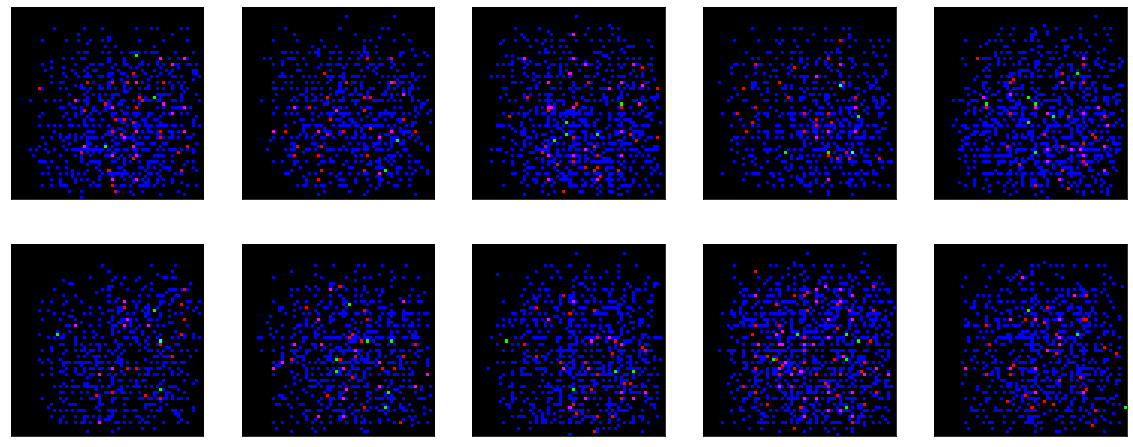

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(gererated_imgs.shape[0]):
  plt.subplot(2, 5, i+1)
  img = image.array_to_img(gererated_imgs[i] * 255, scale=False)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

plt.show()